https://huggingface.co/DunnBC22/efficientformer-l3-300-Brain_Tumors_Image_Classification

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [3]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.HorizontalFlip(p=HFLIPVAL),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}

Training Images:


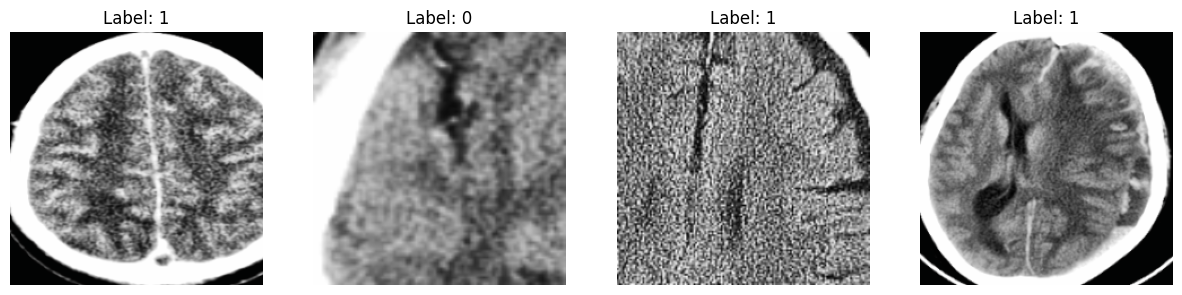

Validation Images:


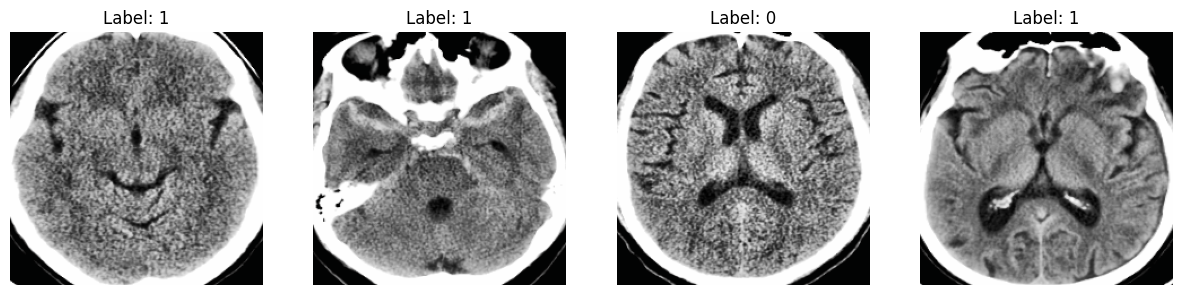

In [5]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction HugginFace pre-trained model


In [6]:
from transformers import AutoConfig, AutoModel


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model
config = AutoConfig.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--DunnBC22--efficientformer-l3-300-Brain_Tumors_Image_Classification')
efficient_model = AutoModel.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--DunnBC22--efficientformer-l3-300-Brain_Tumors_Image_Classification', config=config)

for param in efficient_model.parameters():
    param.requires_grad = False

efficient_model

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


EfficientFormerModel(
  (patch_embed): EfficientFormerConvStem(
    (convolution1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm_before): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convolution2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm_after): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (encoder): EfficientFormerEncoder(
    (intermediate_stages): ModuleList(
      (0): EfficientFormerIntermediateStage(
        (meta4D_layers): EfficientFormerMeta4DLayers(
          (blocks): ModuleList(
            (0-3): 4 x EfficientFormerMeta4D(
              (token_mixer): EfficientFormerPooling(
                (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
              )
              (mlp): EfficientFormerConvMlp(
                (convolution1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
         

In [7]:
efficient_model.named_children()

<generator object Module.named_children at 0x000001937B3FD210>

In [8]:
import torch.nn as nn

class ModifiedEfficientFormerModel(nn.Module):
    def __init__(self, efficient_former_model):
        super(ModifiedEfficientFormerModel, self).__init__()
        
        # Copy the efficient_former_model excluding the last_stage
        self.efficient_former_model = nn.Module()
        for name, module in efficient_former_model.named_children():
            if name != 'last_stage':
                setattr(self.efficient_former_model, name, module)
        
        # Define the classifier layer
        self.classifier = nn.Linear(512, 2)  # Assuming the final feature map has a dimension of 512

    def forward(self, x):
        # Assuming the last layer before 'last_stage' returns a tensor with shape [batch_size, seq_len, dim]
        x = self.efficient_former_model(x)
        
        # Extract the CLS token or use global average pooling
        x = x[:, 0, :]  # for CLS token
        
        # Alternatively, for global average pooling:
        # x = torch.mean(x, dim=1)
        
        x = self.classifier(x)
        return x

# Usage
model = ModifiedEfficientFormerModel(efficient_model).to(device)


In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                                 Param #
ModifiedEfficientFormerModel                                           --
├─Module: 1-1                                                          --
│    └─EfficientFormerConvStem: 2-1                                    --
│    │    └─Conv2d: 3-1                                                (896)
│    │    └─BatchNorm2d: 3-2                                           (64)
│    │    └─Conv2d: 3-3                                                (18,496)
│    │    └─BatchNorm2d: 3-4                                           (128)
│    │    └─ReLU: 3-5                                                  --
│    └─EfficientFormerEncoder: 2-2                                     --
│    │    └─ModuleList: 3-6                                            (12,483,904)
│    │    └─EfficientFormerLastStage: 3-7                              (17,875,488)
│    └─LayerNorm: 2-3                                                  (1

In [20]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Here we will save the metrics
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch}", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train|
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store the loss and accuracy values
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [21]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


NotImplementedError: Module [Module] is missing the required "forward" function

In [11]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[569 114]
 [306 202]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       683
           1       0.64      0.40      0.49       508

    accuracy                           0.65      1191
   macro avg       0.64      0.62      0.61      1191
weighted avg       0.65      0.65      0.63      1191



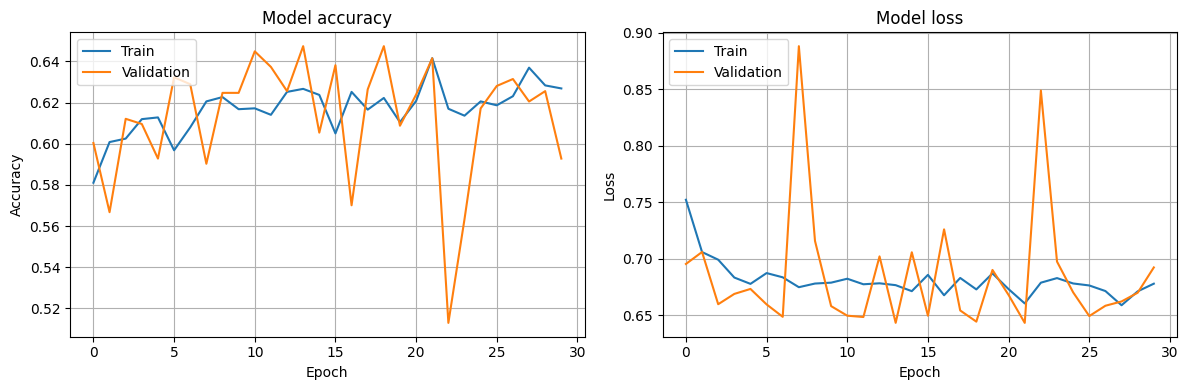

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
bestmodel = {
    'model': model,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(bestmodel, 'EfficientFormerModel_DomainAdaption_Truncation_BrainTumor_PreTrained.pth')
